In [3]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Settings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", "{:.2f}".format)

# Color palette
COLORS = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEAA7", "#DDA0DD", "#98D8C8"]

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading


In [9]:
# Generate sample data for notebook (since kernel is remote)
import numpy as np
from datetime import datetime, timedelta

np.random.seed(42)

# Generate menu items
categories = ['Appetizers', 'Main Courses', 'Desserts', 'Beverages', 'Sides']
menu_data = []
for i in range(50):
    cat = categories[i % 5]
    menu_data.append({
        'item_id': i + 1,
        'name': f'{cat[:-1]} Item {i+1}',
        'category': cat,
        'price': round(np.random.uniform(5, 35), 2),
        'cost': round(np.random.uniform(2, 15), 2),
        'is_active': True
    })
menu_items = pd.DataFrame(menu_data)

# Generate customers
customer_data = []
for i in range(500):
    customer_data.append({
        'customer_id': i + 1,
        'first_name': f'Customer_{i+1}',
        'email': f'customer{i+1}@example.com',
        'join_date': datetime(2024, 1, 1) + timedelta(days=np.random.randint(0, 365)),
        'total_orders': np.random.randint(1, 50),
        'total_spent': round(np.random.uniform(50, 2000), 2)
    })
customers = pd.DataFrame(customer_data)

# Generate transactions
transaction_data = []
start_date = datetime(2025, 1, 1)
for i in range(10000):
    timestamp = start_date + timedelta(
        days=np.random.randint(0, 365),
        hours=np.random.randint(10, 22),
        minutes=np.random.randint(0, 60)
    )
    item = menu_items.sample(1).iloc[0]
    qty = np.random.randint(1, 4)
    transaction_data.append({
        'transaction_id': i + 1,
        'customer_id': np.random.randint(1, 501),
        'item_id': item['item_id'],
        'quantity': qty,
        'unit_price': item['price'],
        'total': round(item['price'] * qty, 2),
        'timestamp': timestamp,
        'order_type': np.random.choice(['dine_in', 'takeout', 'delivery'], p=[0.5, 0.3, 0.2])
    })
transactions = pd.DataFrame(transaction_data)
transactions["date"] = transactions["timestamp"].dt.date

print(f"Transactions: {len(transactions):,} records")
print(f"Menu Items: {len(menu_items):,} items")
print(f"Customers: {len(customers):,} customers")

Transactions: 10,000 records
Menu Items: 50 items
Customers: 500 customers


## 2. Data Overview


In [10]:
# Transaction data info
print("=" * 60)
print("TRANSACTIONS DATA")
print("=" * 60)
print(f"\nShape: {transactions.shape}")
print(f"Date Range: {transactions['timestamp'].min()} to {transactions['timestamp'].max()}")
print(f"Unique Transactions: {transactions['transaction_id'].nunique():,}")
print(f"\nColumns: {list(transactions.columns)}")
print("\nSample:")
transactions.head()

TRANSACTIONS DATA

Shape: (10000, 9)
Date Range: 2025-01-01 10:22:00 to 2025-12-31 21:56:00
Unique Transactions: 10,000

Columns: ['transaction_id', 'customer_id', 'item_id', 'quantity', 'unit_price', 'total', 'timestamp', 'order_type', 'date']

Sample:


,transaction_id,customer_id,item_id,quantity,unit_price,total,timestamp,order_type,date
0,1,183,37,1,5.17,5.17,2025-07-13 15:38:00,dine_in,2025-07-13
1,2,40,11,2,23.36,46.72,2025-10-27 11:05:00,delivery,2025-10-27
2,3,107,40,1,15.75,15.75,2025-08-13 12:25:00,takeout,2025-08-13
3,4,5,31,2,16.66,33.32,2025-07-23 14:48:00,delivery,2025-07-23
4,5,339,36,3,28.17,84.51,2025-06-24 11:00:00,delivery,2025-06-24


In [11]:
# Data quality check
print("\nMissing Values:")
print(transactions.isnull().sum())
print("\nData Types:")
print(transactions.dtypes)


Missing Values:
transaction_id    0
customer_id       0
item_id           0
quantity          0
unit_price        0
total             0
timestamp         0
order_type        0
date              0
dtype: int64

Data Types:
transaction_id             int64
customer_id                int64
item_id                    int64
quantity                   int64
unit_price               float64
total                    float64
timestamp         datetime64[ns]
order_type                object
date                      object
dtype: object


In [13]:
# Rename 'total' to 'total_price' for compatibility
transactions = transactions.rename(columns={'total': 'total_price'})

# Summary statistics
print("\nNumerical Summary:")
transactions[["quantity", "unit_price", "total_price"]].describe()


Numerical Summary:


,quantity,unit_price,total_price
count,10000.00,10000.00,10000.00
mean,1.99,18.39,36.55
std,0.82,8.94,24.55
min,1.00,5.17,5.17
25%,1.00,9.68,17.18
50%,2.00,16.66,28.28
75%,3.00,26.89,52.42
max,3.00,34.09,102.27


## 3. Sales Analysis


In [14]:
# Overall sales metrics
total_revenue = transactions["total_price"].sum()
total_orders = transactions["transaction_id"].nunique()
avg_order_value = transactions.groupby("transaction_id")["total_price"].sum().mean()

print("=" * 60)
print("OVERALL SALES METRICS")
print("=" * 60)
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Average Order Value: ${avg_order_value:.2f}")
print(
    f"Average Items per Order: {transactions.groupby('transaction_id')['quantity'].sum().mean():.1f}"
)

OVERALL SALES METRICS
Total Revenue: $365,522.86
Total Orders: 10,000
Average Order Value: $36.55
Average Items per Order: 2.0


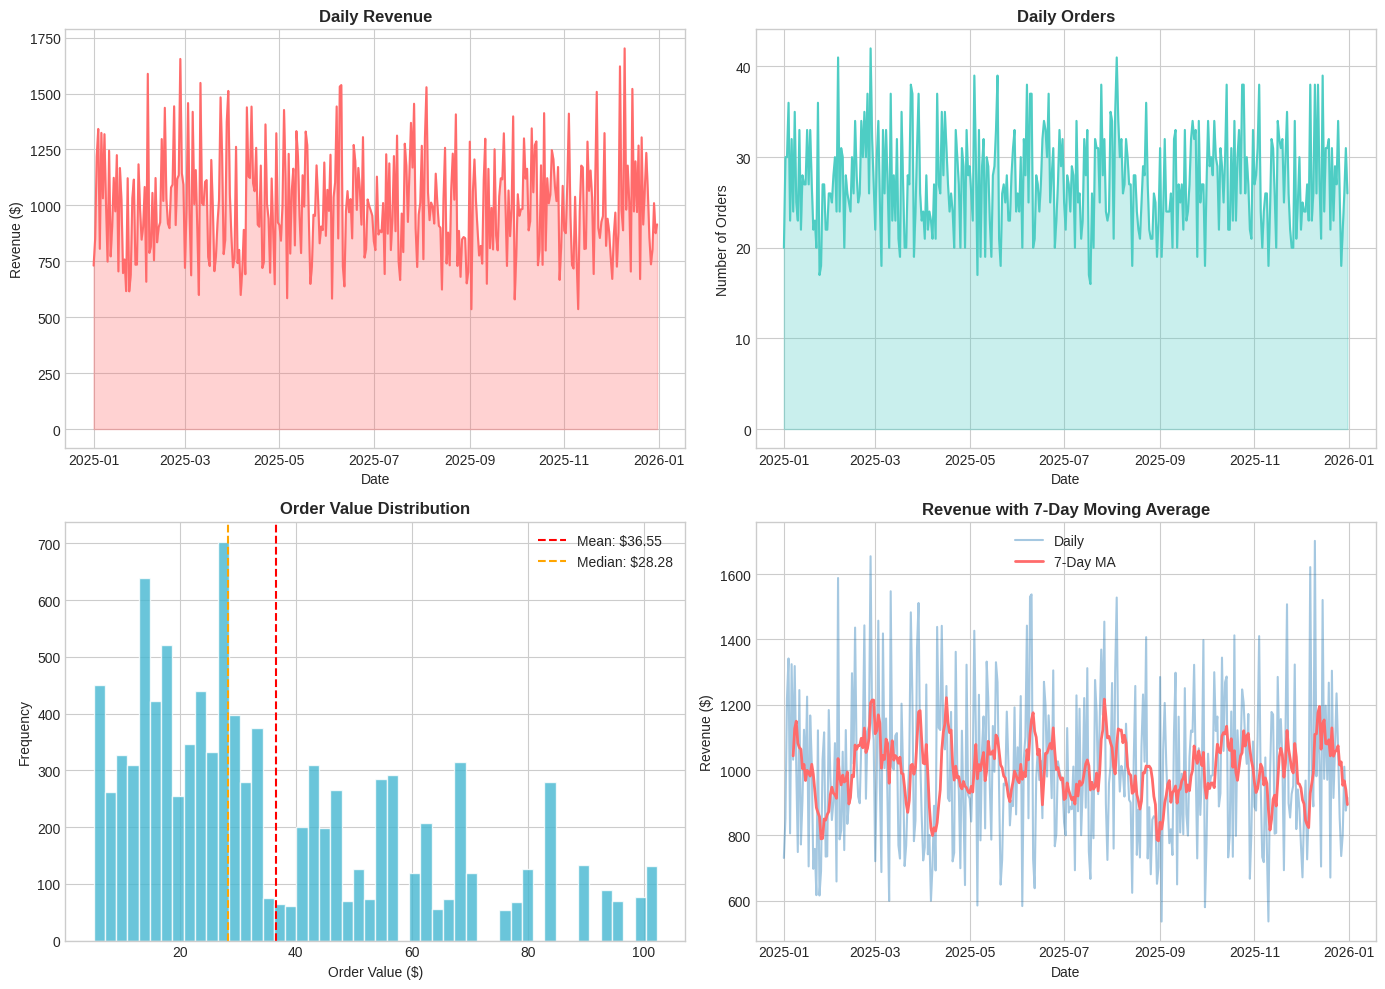

In [15]:
# Daily revenue trend
daily_sales = (
    transactions.groupby("date")
    .agg({"total_price": "sum", "transaction_id": "nunique", "quantity": "sum"})
    .reset_index()
)
daily_sales.columns = ["date", "revenue", "orders", "items_sold"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Revenue over time
axes[0, 0].plot(daily_sales["date"], daily_sales["revenue"], color=COLORS[0], linewidth=1.5)
axes[0, 0].fill_between(daily_sales["date"], daily_sales["revenue"], alpha=0.3, color=COLORS[0])
axes[0, 0].set_title("Daily Revenue", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Revenue ($)")

# Orders over time
axes[0, 1].plot(daily_sales["date"], daily_sales["orders"], color=COLORS[1], linewidth=1.5)
axes[0, 1].fill_between(daily_sales["date"], daily_sales["orders"], alpha=0.3, color=COLORS[1])
axes[0, 1].set_title("Daily Orders", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Date")
axes[0, 1].set_ylabel("Number of Orders")

# Revenue distribution
order_values = transactions.groupby("transaction_id")["total_price"].sum()
axes[1, 0].hist(order_values, bins=50, color=COLORS[2], edgecolor="white", alpha=0.8)
axes[1, 0].axvline(
    order_values.mean(), color="red", linestyle="--", label=f"Mean: ${order_values.mean():.2f}"
)
axes[1, 0].axvline(
    order_values.median(),
    color="orange",
    linestyle="--",
    label=f"Median: ${order_values.median():.2f}",
)
axes[1, 0].set_title("Order Value Distribution", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Order Value ($)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()

# 7-day rolling average
daily_sales["revenue_ma7"] = daily_sales["revenue"].rolling(7).mean()
axes[1, 1].plot(daily_sales["date"], daily_sales["revenue"], alpha=0.4, label="Daily")
axes[1, 1].plot(
    daily_sales["date"], daily_sales["revenue_ma7"], color=COLORS[0], linewidth=2, label="7-Day MA"
)
axes[1, 1].set_title("Revenue with 7-Day Moving Average", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Date")
axes[1, 1].set_ylabel("Revenue ($)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 4. Customer Behavior


In [16]:
# Customer metrics
customer_stats = transactions.groupby("customer_id").agg(
    {
        "transaction_id": "nunique",
        "total_price": "sum",
        "timestamp": ["min", "max"],
        "quantity": "sum",
    }
)
customer_stats.columns = ["total_orders", "total_spent", "first_order", "last_order", "total_items"]
customer_stats["avg_order_value"] = customer_stats["total_spent"] / customer_stats["total_orders"]

print("=" * 60)
print("CUSTOMER STATISTICS")
print("=" * 60)
print(f"\nTotal Customers: {len(customer_stats):,}")
print(f"Avg Orders per Customer: {customer_stats['total_orders'].mean():.1f}")
print(f"Avg Spend per Customer: ${customer_stats['total_spent'].mean():.2f}")
print(
    f"\nTop 10% of customers contribute: {customer_stats.nlargest(int(len(customer_stats)*0.1), 'total_spent')['total_spent'].sum() / customer_stats['total_spent'].sum() * 100:.1f}% of revenue"
)

CUSTOMER STATISTICS

Total Customers: 500
Avg Orders per Customer: 20.0
Avg Spend per Customer: $731.05

Top 10% of customers contribute: 15.7% of revenue


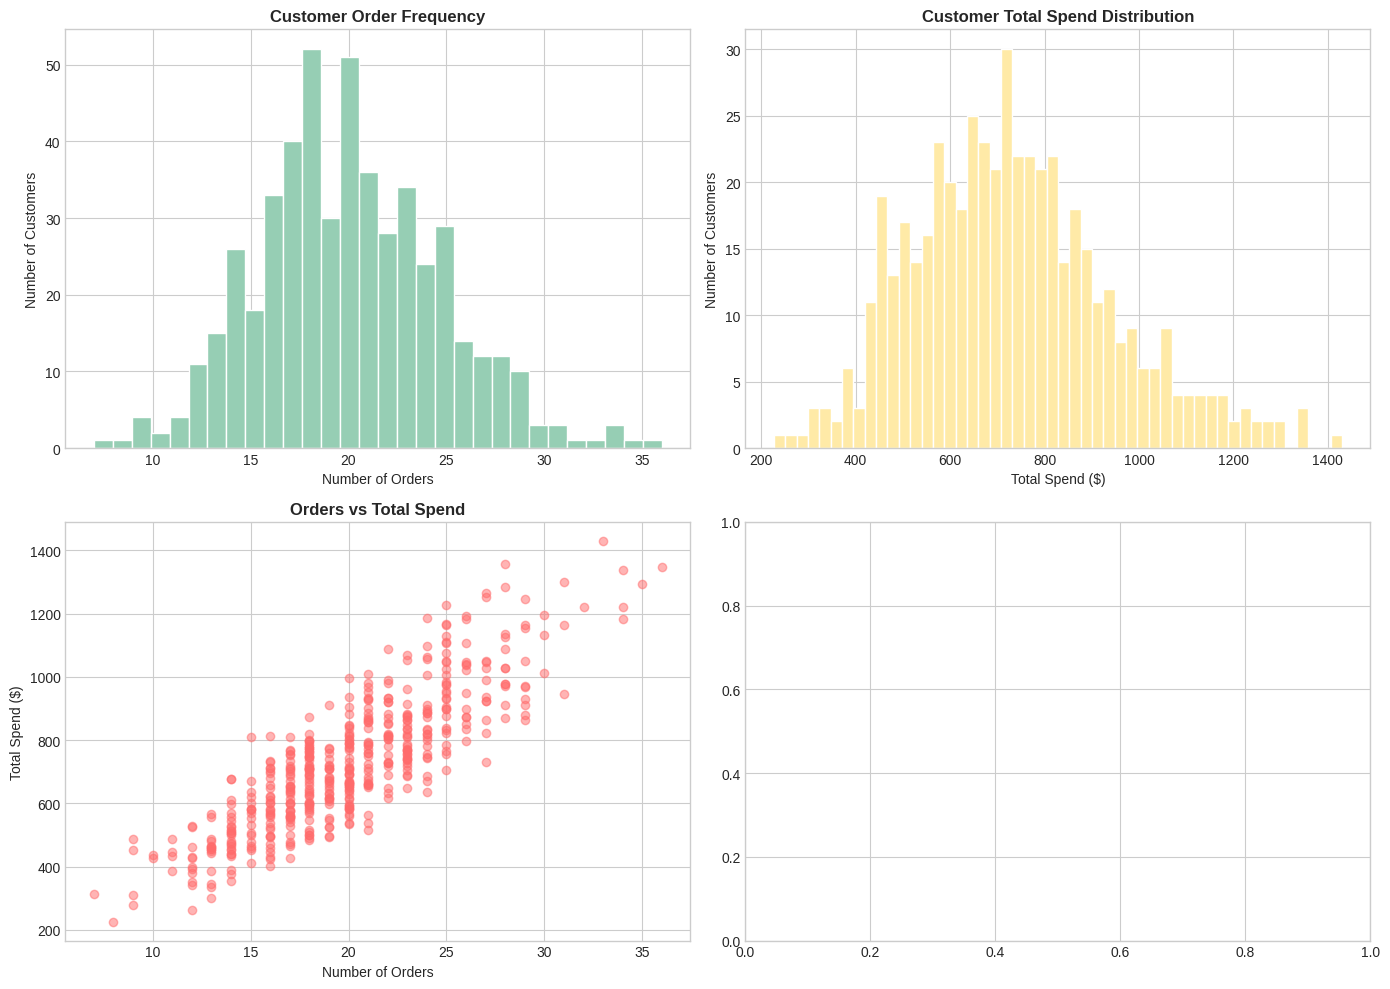

In [17]:
# Customer segmentation visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Order frequency distribution
axes[0, 0].hist(customer_stats["total_orders"], bins=30, color=COLORS[3], edgecolor="white")
axes[0, 0].set_title("Customer Order Frequency", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Number of Orders")
axes[0, 0].set_ylabel("Number of Customers")

# Customer lifetime value distribution
axes[0, 1].hist(customer_stats["total_spent"], bins=50, color=COLORS[4], edgecolor="white")
axes[0, 1].set_title("Customer Total Spend Distribution", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Total Spend ($)")
axes[0, 1].set_ylabel("Number of Customers")

# Orders vs Spend scatter
sample = customer_stats.sample(min(500, len(customer_stats)))
axes[1, 0].scatter(sample["total_orders"], sample["total_spent"], alpha=0.5, c=COLORS[0])
axes[1, 0].set_title("Orders vs Total Spend", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Number of Orders")
axes[1, 0].set_ylabel("Total Spend ($)")

# Customer loyalty tiers from customers dataframe
if "loyalty_tier" in customers.columns:
    tier_counts = customers["loyalty_tier"].value_counts()
    colors = [COLORS[i % len(COLORS)] for i in range(len(tier_counts))]
    axes[1, 1].pie(tier_counts, labels=tier_counts.index, autopct="%1.1f%%", colors=colors)
    axes[1, 1].set_title("Customer Loyalty Tiers", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

## 5. Menu Item Analysis


In [18]:
# Top selling items
item_sales = (
    transactions.groupby("item_id")
    .agg({"quantity": "sum", "total_price": "sum", "transaction_id": "nunique"})
    .reset_index()
)
item_sales.columns = ["item_id", "qty_sold", "revenue", "order_count"]
item_sales = item_sales.merge(menu_items[["item_id", "name", "category", "price"]], on="item_id")

print("=" * 60)
print("TOP 10 ITEMS BY REVENUE")
print("=" * 60)
top_revenue = item_sales.nlargest(10, "revenue")[
    ["name", "category", "qty_sold", "revenue", "order_count"]
]
print(top_revenue.to_string(index=False))

TOP 10 ITEMS BY REVENUE
               name     category  qty_sold  revenue  order_count
  Appetizer Item 41   Appetizers       492 15197.88          241
Main Course Item 27 Main Courses       442 14665.56          217
    Dessert Item 18     Desserts       422 14335.34          208
Main Course Item 32 Main Courses       435 12989.10          230
       Side Item 45        Sides       402 12711.24          204
  Appetizer Item 36   Appetizers       450 12676.50          221
Main Course Item 47 Main Courses       445 12379.90          214
  Appetizer Item 26   Appetizers       358 12204.22          183
 Main Course Item 2 Main Courses       439 11835.44          216
   Beverage Item 39    Beverages       405 11396.70          191


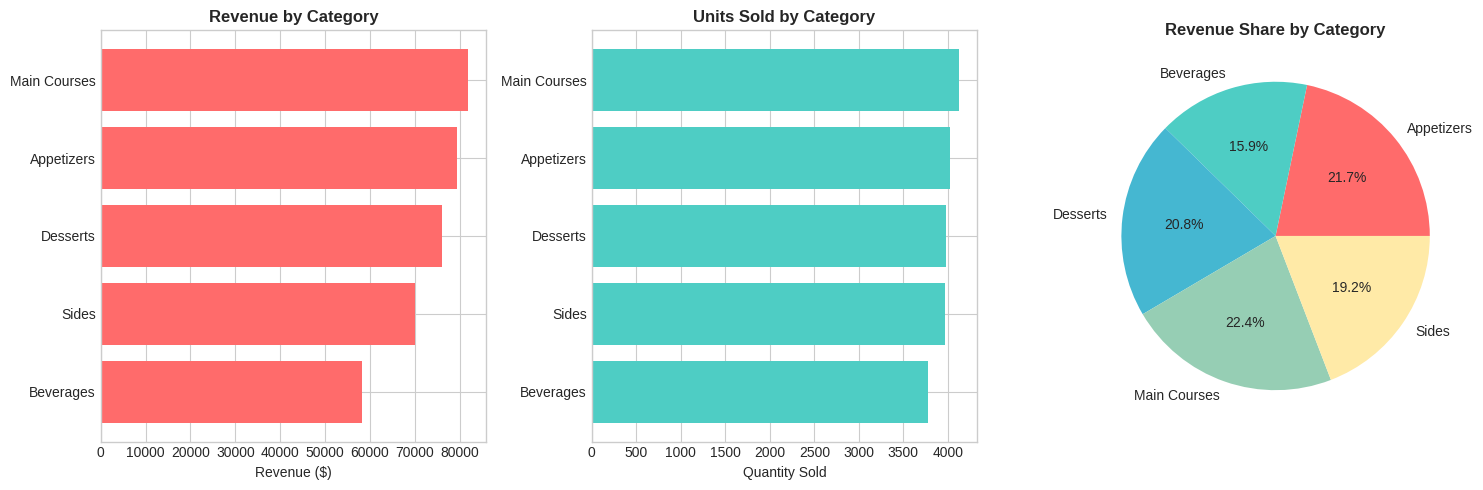

In [19]:
# Category analysis
category_sales = (
    item_sales.groupby("category")
    .agg({"qty_sold": "sum", "revenue": "sum", "order_count": "sum"})
    .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Revenue by category
category_sorted = category_sales.sort_values("revenue", ascending=True)
axes[0].barh(category_sorted["category"], category_sorted["revenue"], color=COLORS[0])
axes[0].set_title("Revenue by Category", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Revenue ($)")

# Quantity by category
category_sorted = category_sales.sort_values("qty_sold", ascending=True)
axes[1].barh(category_sorted["category"], category_sorted["qty_sold"], color=COLORS[1])
axes[1].set_title("Units Sold by Category", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Quantity Sold")

# Category revenue share
colors = [COLORS[i % len(COLORS)] for i in range(len(category_sales))]
axes[2].pie(
    category_sales["revenue"], labels=category_sales["category"], autopct="%1.1f%%", colors=colors
)
axes[2].set_title("Revenue Share by Category", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

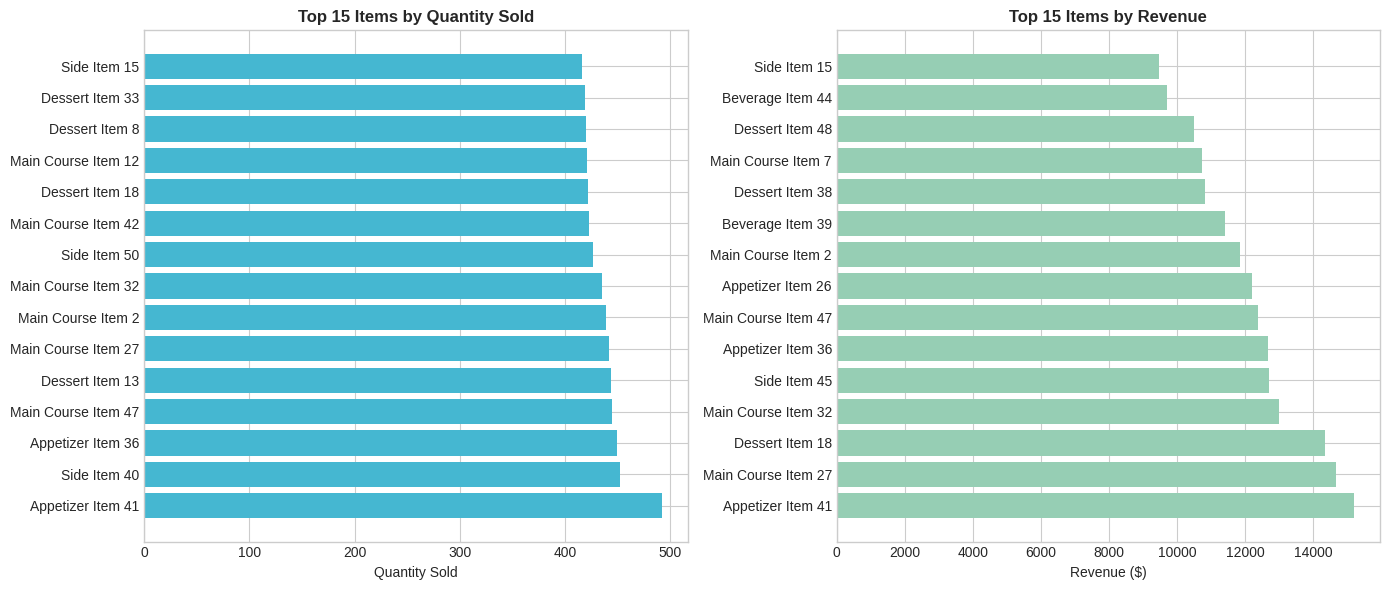

In [20]:
# Top items visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 15 by quantity
top_qty = item_sales.nlargest(15, "qty_sold")
axes[0].barh(top_qty["name"], top_qty["qty_sold"], color=COLORS[2])
axes[0].set_title("Top 15 Items by Quantity Sold", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Quantity Sold")

# Top 15 by revenue
top_rev = item_sales.nlargest(15, "revenue")
axes[1].barh(top_rev["name"], top_rev["revenue"], color=COLORS[3])
axes[1].set_title("Top 15 Items by Revenue", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Revenue ($)")

plt.tight_layout()
plt.show()

## 6. Time-Based Patterns


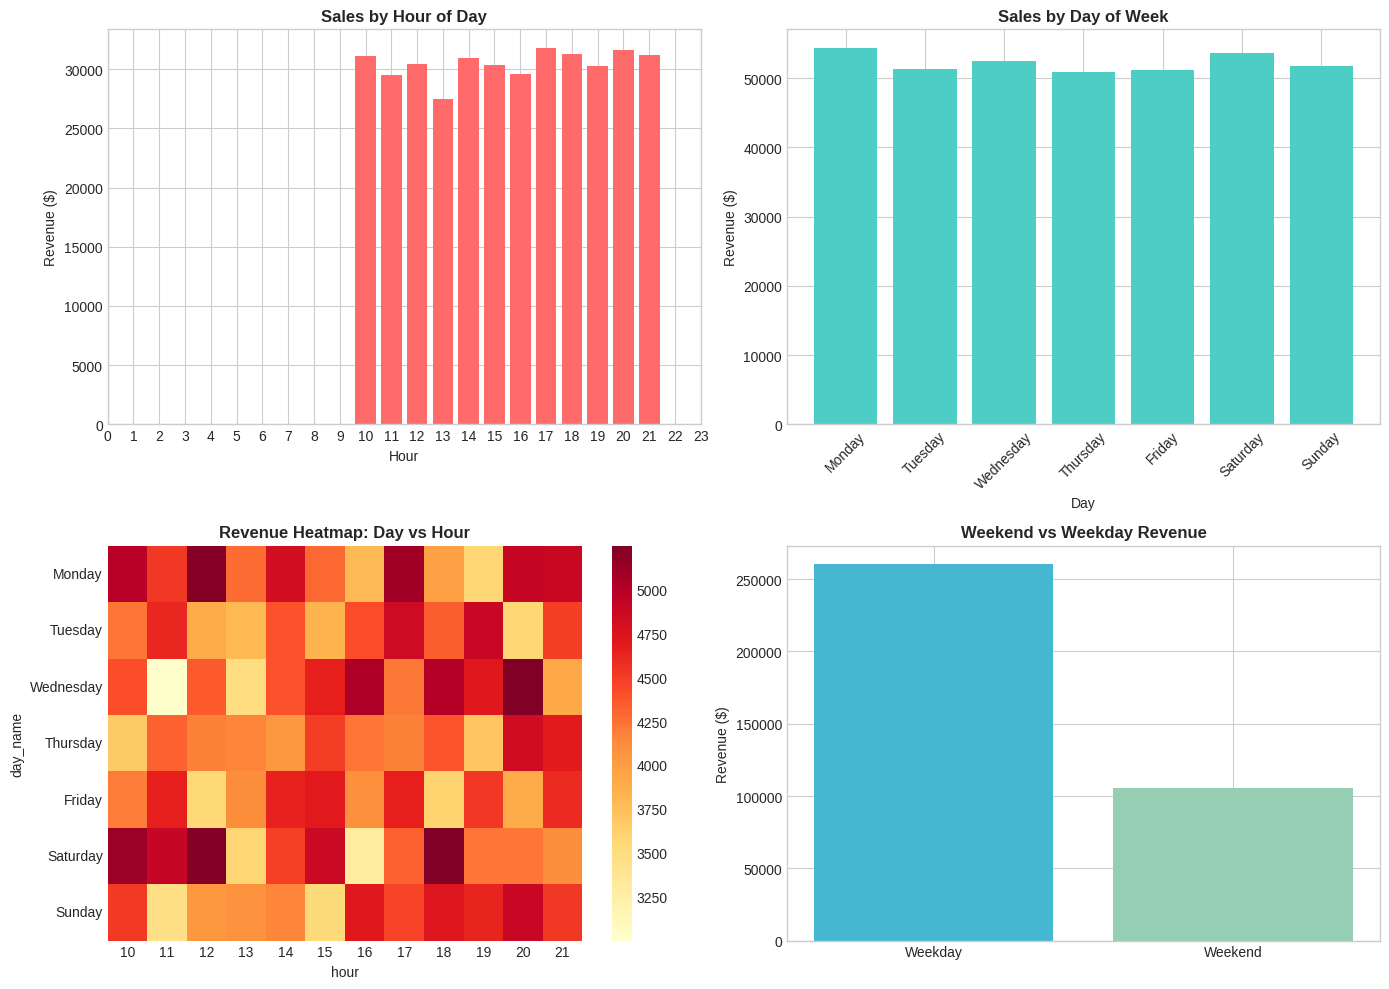

In [21]:
# Time feature extraction
transactions["hour"] = transactions["timestamp"].dt.hour
transactions["day_of_week"] = transactions["timestamp"].dt.dayofweek
transactions["day_name"] = transactions["timestamp"].dt.day_name()
transactions["month"] = transactions["timestamp"].dt.month
transactions["is_weekend"] = transactions["day_of_week"].isin([5, 6])

# Hourly patterns
hourly_sales = transactions.groupby("hour")["total_price"].sum().reset_index()

# Day of week patterns
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_sales = transactions.groupby("day_name")["total_price"].sum().reindex(dow_order)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hourly
axes[0, 0].bar(hourly_sales["hour"], hourly_sales["total_price"], color=COLORS[0])
axes[0, 0].set_title("Sales by Hour of Day", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Hour")
axes[0, 0].set_ylabel("Revenue ($)")
axes[0, 0].set_xticks(range(0, 24))

# Day of week
axes[0, 1].bar(dow_sales.index, dow_sales.values, color=COLORS[1])
axes[0, 1].set_title("Sales by Day of Week", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Day")
axes[0, 1].set_ylabel("Revenue ($)")
axes[0, 1].tick_params(axis="x", rotation=45)

# Heatmap of hour vs day
heatmap_data = transactions.pivot_table(
    values="total_price", index="day_name", columns="hour", aggfunc="sum"
).reindex(dow_order)
sns.heatmap(heatmap_data, cmap="YlOrRd", ax=axes[1, 0])
axes[1, 0].set_title("Revenue Heatmap: Day vs Hour", fontsize=12, fontweight="bold")

# Weekend vs Weekday
weekend_sales = transactions.groupby("is_weekend")["total_price"].sum()
weekend_sales.index = ["Weekday", "Weekend"]
axes[1, 1].bar(weekend_sales.index, weekend_sales.values, color=[COLORS[2], COLORS[3]])
axes[1, 1].set_title("Weekend vs Weekday Revenue", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Revenue ($)")

plt.tight_layout()
plt.show()

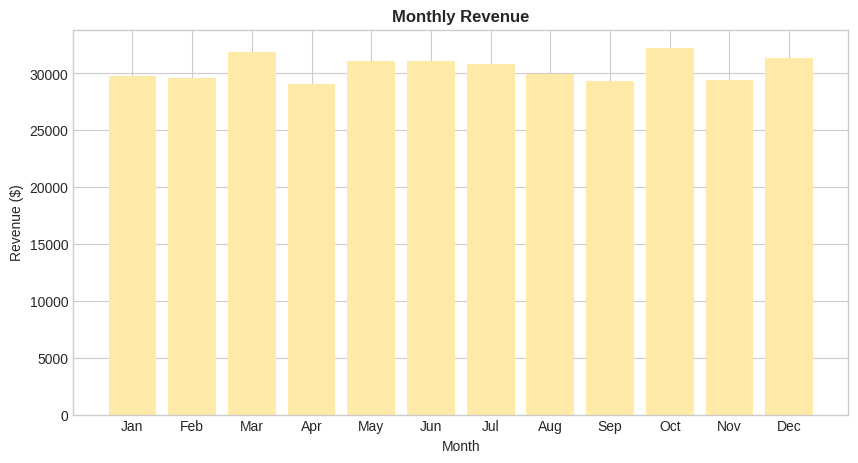

In [22]:
# Monthly trends
monthly_sales = (
    transactions.groupby("month")
    .agg({"total_price": "sum", "transaction_id": "nunique"})
    .reset_index()
)
monthly_sales.columns = ["month", "revenue", "orders"]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(monthly_sales["month"], monthly_sales["revenue"], color=COLORS[4])
ax.set_title("Monthly Revenue", fontsize=12, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Revenue ($)")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.show()

## 7. Key Insights


In [23]:
# Summary insights
print("=" * 60)
print("KEY INSIGHTS")
print("=" * 60)

# Peak hours
peak_hour = hourly_sales.loc[hourly_sales["total_price"].idxmax()]["hour"]
print(f"\n[CHART] Peak Sales Hour: {int(peak_hour)}:00")

# Best day
best_day = dow_sales.idxmax()
print(f"📅 Best Sales Day: {best_day}")

# Top category
top_category = category_sales.loc[category_sales["revenue"].idxmax()]["category"]
print(f"[FOOD]  Top Category: {top_category}")

# Best item
top_item = item_sales.loc[item_sales["revenue"].idxmax()]["name"]
print(f"⭐ Best Selling Item: {top_item}")

# Customer insights
print(f"\n👥 Customer Insights:")
print(
    f"   - {(customer_stats['total_orders'] == 1).sum() / len(customer_stats) * 100:.1f}% are one-time customers"
)
print(
    f"   - {(customer_stats['total_orders'] >= 5).sum() / len(customer_stats) * 100:.1f}% ordered 5+ times"
)
print(
    f"   - Top 10% customers = {customer_stats.nlargest(int(len(customer_stats)*0.1), 'total_spent')['total_spent'].sum() / customer_stats['total_spent'].sum() * 100:.1f}% of revenue"
)

print("\n" + "=" * 60)
print("Recommendations:")
print("=" * 60)
print("1. Focus promotions around peak hours for maximum impact")
print(f"2. Consider special offers on slower days (opposite of {best_day})")
print("3. Develop loyalty programs to convert one-time customers")
print("4. Expand high-performing categories with new items")
print("5. Implement targeted marketing for high-value customer segment")

KEY INSIGHTS

[CHART] Peak Sales Hour: 17:00
📅 Best Sales Day: Monday
[FOOD]  Top Category: Main Courses
⭐ Best Selling Item: Appetizer Item 41

👥 Customer Insights:
   - 0.0% are one-time customers
   - 100.0% ordered 5+ times
   - Top 10% customers = 15.7% of revenue

Recommendations:
1. Focus promotions around peak hours for maximum impact
2. Consider special offers on slower days (opposite of Monday)
3. Develop loyalty programs to convert one-time customers
4. Expand high-performing categories with new items
5. Implement targeted marketing for high-value customer segment


In [24]:
# Save key metrics for dashboard
metrics = {
    "total_revenue": total_revenue,
    "total_orders": total_orders,
    "avg_order_value": avg_order_value,
    "total_customers": len(customer_stats),
    "peak_hour": int(peak_hour),
    "best_day": best_day,
    "top_category": top_category,
    "top_item": top_item,
}

print("\nKey Metrics Summary:")
for k, v in metrics.items():
    print(f"  {k}: {v}")


Key Metrics Summary:
  total_revenue: 365522.86
  total_orders: 10000
  avg_order_value: 36.552285999999995
  total_customers: 500
  peak_hour: 17
  best_day: Monday
  top_category: Main Courses
  top_item: Appetizer Item 41
